https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html

In [28]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid

In [21]:
class MoneyAgent(Agent):
    """個々のエージェント"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        """スケジューラ"""
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents) # ランダムに他のエージェントを選択する
        other_agent.wealth += 1 # ランダムに選んだエージェントにwelthを付与する
        self.wealth -= 1 # 自分のwealthをマイナス１する
        
class MoneyModel(Model):
    """エージェント全体"""
    def __init__(self, N):
        self.num_agents = N # エージェントの総数
        self.schedule = RandomActivation(self) # エージェントをシャッフルする
        # エージェント作成 : MoneyModelを作成すると自動でエージェントモデルも作成される
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        """スケジューラ"""
        self.schedule.step()

In [22]:
# 10step 実行
model = MoneyModel(10)
for i in range(10):
    model.step()

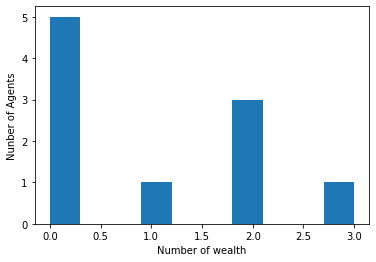

In [23]:
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

# For jupyter notebook add the following line:
%matplotlib inline

agent_wealth = [a.wealth for a in model.schedule.agents]
# print(agent_wealth)
plt.xlabel("Number of wealth") # 持っているwealthの数
plt.ylabel("Nunber of Agents") # そのwealthを持っているAgentの数
plt.hist(agent_wealth)
#For a script add the following line
plt.show()

(array([437., 290., 169.,  66.,  20.,  18.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

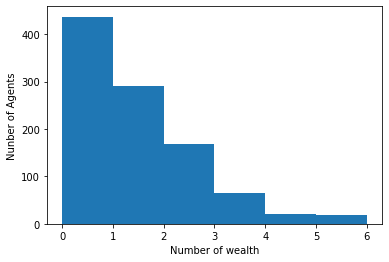

In [24]:
# 10step繰り返すのを100回行う
all_wealth = []
for j in range(100):
    # モデルを生成する
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    #　結果を保存する
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)
# print(all_wealth)
plt.xlabel("Number of wealth") # 持っているwealthの数
plt.ylabel("Nunber of Agents") # そのwealthを持っているAgentの数
plt.hist(all_wealth, bins=range(max(all_wealth)+1))

In [25]:
# 空間配置を考慮したモデル
class MoneyAgent(Agent):
    """個々のエージェント"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        """セルの移動"""
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        """現セルから+-1のところにどうする処理
        neighbors = []
        x, y = self.pos
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                neighbors.append((x+dx, y+dy))
        """
    
    def give_money(self):
        """移動が発生した際に富を交換する処理"""
        cellmates = self.model.grid.get_cell_list_contents([self.pos]) # そのエージェントの近くのセルを取得
        if len(cellmates) > 1:
            other = self.random.choice(cellmates) # 近くのセルのうちからランダムで取得
            other.wealth += 1
            self.wealth -= 1
    
    def step(self):
        """スケジューラ"""
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True) # 空間を定義
        self.schedule = RandomActivation(self)

        # エージェントを作成
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # ランダムにエージェントを配置する
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y)) # ランダムに配置する
    
    def step(self):
        self.schedule.step()
        

In [26]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

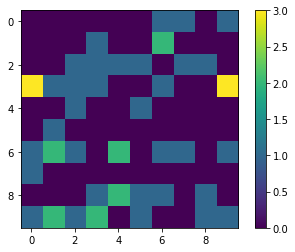

In [27]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [29]:
# データコレクターの追加
def compute_gini(model):
    """ ジニ係数を計算 """
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

# 以下、compute_gini部分以外同様
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [30]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

<AxesSubplot:>

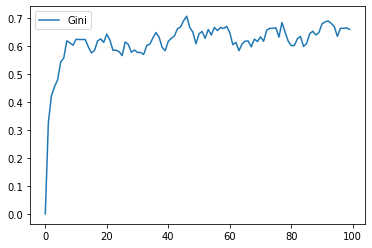

In [31]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()


In [32]:
# 初期状態
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

<AxesSubplot:>

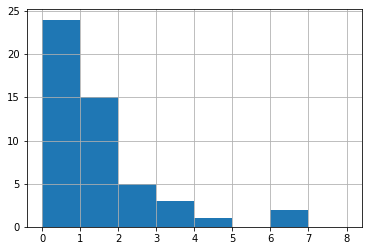

In [33]:
# 最終結果
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

<AxesSubplot:xlabel='Step'>

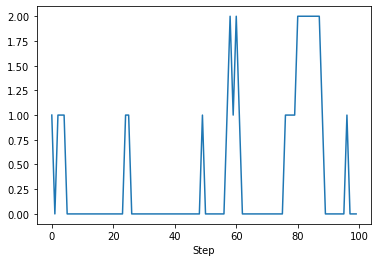

In [34]:
# 一つのエージェントの推移
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [ ]:
# ABM